## Attempt at improving the spectra

In [64]:
# wavelengths to look for in object J112714-C at z=2.2352 
# name: [rest_wl, obs_wl]

wavelengths_J112714C_2_2352 = {}

In [65]:
import glob
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from specutils import Spectrum1D
from regions import Regions
from regions import RectangleSkyRegion

# Use the read method with the format explicitly set
# regions = Regions.read('my_regions.reg', format='ds9')

In [66]:
redshift = 2.2352
DS9_REGION_FILE = Regions.read("/home/fatih/G165_main/G165_miri_bg_subtraction/data/carta_regions/use_this_regions", format="ds9")
CUBE_GLOB = "/home/fatih/G165_main/G165_miri_bg_subtraction/miri_notebook/mrs_data/Obs003/stage3/Level3_ch3-*_s3d.fits"
OUTPUT_PNG = "spectrum_stitched.png"

In [ ]:
# | HDU | Name      | Description                                                                       |
# | --- | --------- | --------------------------------------------------------------------------------- |
# | 0   | `PRIMARY` | This is just the header — no image data (empty `()` shape).                       |
# | 1   | `SCI`     | Science data cube — a 3D image with shape (45, 45, 1400), stored as `float32`     |
# | 2   | `ERR`     | Error estimates for the science data, same shape.                                 |
# | 3   | `DQ`      | Data quality flags (integers).                                                    |
# | 4   | `WMAP`    | Possibly a weight map or exposure map.                                            |
# | 5   | `HDRTAB`  | Metadata (headers, config). Not image data.                                       |
# | 6   | `ASDF`    | Metadata blob in ASDF format (used by JWST/MIRI pipeline).                        |

def load_cube_and_wcs(filename):
    """Loads cube data and WCS from a MIRI Level3 IFU cube."""
    hdul = fits.open(filename)
    data = hdul["SCI"].data
    header = hdul["SCI"].header

    # WCS with spectral + two spatial axes
    

    wcs = WCS(header)
    return data, wcs

def extract_1d_spec_from_region(cube, wcs, ds9_regions):
    """Convert world DS9 region to mask in pixel coords, sum flux."""
    # First, convert (RA/DEC) from DS9 regions to pixel values, then mask
    pixel_region = ds9_regions.to_pixel(wcs.celestial)
    mask = pixel_region.to_mask(mode="center")  # center = pixel inside region
    pix_mask = mask.to_image(cube.shape[1:])   # shape: (ny, nx)

    # apply mask: sum over spaxels inside region
    # spectral axis is axis=0, so sum over spatial dims
    with np.errstate(invalid="ignore"):
        masked_cube = cube[:, pix_mask.astype(bool)]

    spec_1d = np.nansum(masked_cube, axis=1)
    return spec_1d

def get_wavelength_axis(wcs, n_wave): # (?)
    crval = header["CRVAL3"]   # reference wavelength (meters)
    cdelt = header["CDELT3"]   # wavelength step (meters)
    crpix = header["CRPIX3"]   # reference pixel (1-based)

    pixel = np.arange(n_wave)
    wavelength_m = crval + (pixel + 1 - crpix) * cdelt

    return wavelength_m * 1e6  # convert meters → microns
    

In [68]:
ds9_regions = DS9_REGION_FILE[11]
cube_files = sorted(glob.glob(CUBE_GLOB))
print("Found cubes:", cube_files)



all_wavelengths = []
all_fluxes = []

for cube_file in cube_files:
    print("loading cube...")
    cube, wcs = load_cube_and_wcs(cube_file)

    spec1d = extract_1d_spec_from_region(cube, wcs, ds9_regions)

    n_wave = spec1d.shape[0]
    lam = get_wavelength_axis(wcs, n_wave)

    all_wavelengths.append(lam)
    all_fluxes.append(spec1d)

wave_full = np.concatenate(all_wavelengths)
flux_full = np.concatenate(all_fluxes)

# sort by wavelength
order = np.argsort(wave_full) # sorts an array and gives them indices
wave_full = wave_full[order]
flux_full = flux_full[order]

# normalize e.g. median if desired
flux_full /= np.median(flux_full)

# make a specutils Spectrum1D
spectrum = Spectrum1D(spectral_axis=wave_full * (1 + redshift) * u.micron, flux=flux_full * u.MJy / u.sr)



Found cubes: ['/home/fatih/G165_main/G165_miri_bg_subtraction/miri_notebook/mrs_data/Obs003/stage3/Level3_ch3-long_s3d.fits', '/home/fatih/G165_main/G165_miri_bg_subtraction/miri_notebook/mrs_data/Obs003/stage3/Level3_ch3-medium_s3d.fits']
loading cube...


Set DATE-AVG to '2024-05-14T20:33:42.768' from MJD-AVG.
Set DATE-END to '2024-05-14T21:40:48.275' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -26.985828 from OBSGEO-[XYZ].
Set OBSGEO-H to 1626787592.699 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


NameError: name 'header' is not defined

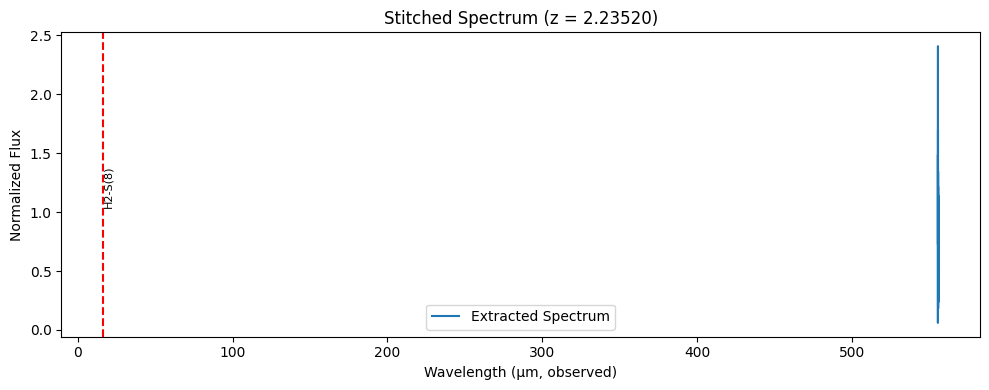

In [60]:
# Plotting

plt.figure(figsize=(10, 4))
plt.plot(spectrum.spectral_axis, spectrum.flux, label="Extracted Spectrum")


plt.xlabel("Wavelength (µm, observed)")
plt.ylabel("Normalized Flux")
plt.title(f"Stitched Spectrum (z = {redshift:.5f})")

rest_lines = {
    #"H₂ S(0)": 28.22,
    #"H₂ S(1)": 17.03,
    #"H₂ S(2)": 12.28,
    #"H₂ S(3)": 9.66,
    #"H₂ S(4)": 8.03,
    #"H₂ S(5)": 6.91,
    "H2-S(8)":5.0530
}


for label, rest in rest_lines.items():
    obs = rest * (1 + redshift)
    plt.axvline(obs, color="red", linestyle="--")
    plt.text(obs, 1.05, label, rotation=90, fontsize=8)

plt.legend()
plt.tight_layout()
#plt.savefig("/home/fatih/G165_main/G165_miri_bg_subtraction/miri_notebook/spec/OUTPUT_PNG")
plt.show()